# ASTR 596: An Emcee Worked example.



In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import emcee
import corner
import astropy.table as at
import scipy.optimize as so
import pandas as pd

Using Emcee for a real problem where a grid would have been really painful.


We'll be analyzing data from the Optical Gravitational Lensing Experiment (OGLE), which monitors stars in our galaxy in the hopes of detecting gravitational microlensing events that occur when a compact mass (e.g. a fainter star) passes in front of the monitored star.

You can read more about microlensing here if you like:
https://en.wikipedia.org/wiki/Gravitational_microlensing

Data are available through the [OGLE Early Warning System](http://ogle.astrouw.edu.pl/ogle4/ews/ews.html). I've chosen this event at random:

<table>
    <tr>
        <td><img src="http://ogle.astrouw.edu.pl/ogle4/ews/2019/data/2019/blg-0001/lcurve.gif" width=75%></td>
    </tr>
</table>

You can pick your own if you like. As long as a vaguely reasonable looking magenta line is shown on the OGLE page, this should be a good data set to fit. Download the `phot.dat` for your chosen event (linked at the bottom of the webpage).

As described on the OGLE page, the columns of this text file are

> Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel) and sky level

* Heliocentric Julian Date. This is time, measured in days, since a fixed reference. The "heliocentric" part means that it has been corrected to the reference frame of the Sun, i.e. the few minutes of light travel time more or less that would affect photon arrivals at different parts of the Earth's year have been subtracted off.

* Measurements of magnitude in the $I$ band (a near infrared band). Recall that astronomical magnitude, relative to a given reference source, is given by the relationship $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$, where $F$ is flux.

* Measurement uncertainty on the $I$ magnitude, defined in some unspecified way (digging through papers might elucidate this).

* The "seeing" and "sky level" quantities refer to the observing conditions, which we will not work with directly. These will have been accounted for (somehow) in deriving the best-fitting magnitude and its uncertainty.


# As with your homework 03 (i.e. this is as big a hint as you get from me):


We have 4 questions to answer
1. What's the model?
2. What's the Likelihood?
3. What's the Prior?
4. How do you sample?


In this case 1 is a known model to describe Microlensing called the [Paczyinski model](https://en.wikipedia.org/wiki/Bohdan_Paczy%C5%84ski). 

## $$F(t) = F_0 \frac{u(t)^2 + 2}{u(t)\sqrt{u(t)^2+4}}$$

where

## $$u(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$$

You'll of course also need the transformation between flux and magnitude, above. For convenience, let's parameterize the normalization of the model lightcurve in magnitudes rather than flux, i.e. $I_0$ rather than $F_0$; that way, all of the "ref" quantities in the magnitude definition are absorbed into this new parameter and we won't have to worry about them explicitly. With that substitution, the model parameters are $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$. 

* $t_\mathrm{E}$ is the Einstein crossing time - you can also get some initial guess for this from the data itself

* $t_\mathrm{max}$ is the time of maximum - which you should be able to read off from the plot

* $p$ is the peak magnification - You can also get a guess of this and $I_0$ from the data. Look at the functional form of the model at times far from $t_\mathrm{max}$.


Lacking any better information, we'll assume that the sampling distributions for the magnitude measurements are Gaussian and independent, with means given by the "magnitude" column and standard deviations given by the "magnitude error" column, and that the time stamps are exact.


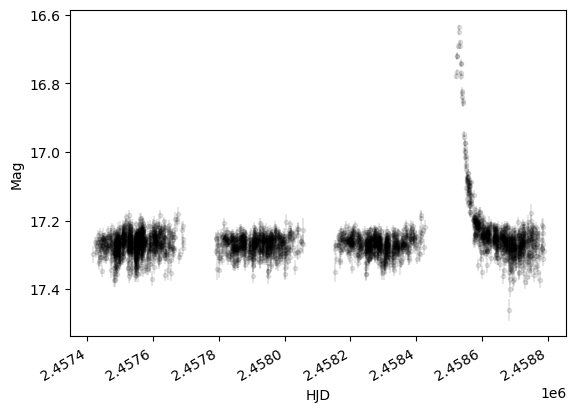

In [2]:
# first let's look at the data


data = at.Table.read('phot.dat', format='ascii', names=['t','y','dy', 'seeing', 'sky'])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(data['t'], data['y'], yerr=data['dy'],\
            linestyle='None', marker='.', color='k', alpha=0.1)
ax.invert_yaxis()
ax.set_xlabel('HJD')
ax.set_ylabel('Mag')
fig.autofmt_xdate()

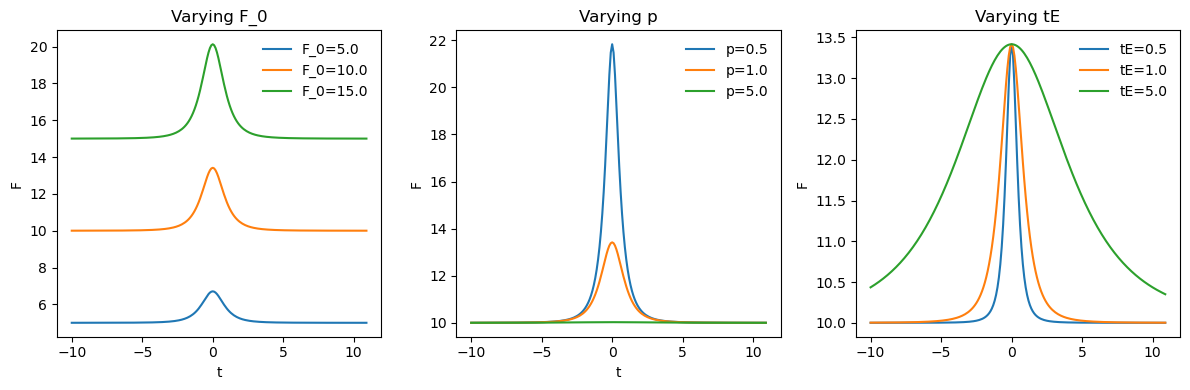

In [3]:
# lets declare a variable with the number of model dimensions
ndim = 4


def model(F_0, p, tmax, tE, t):   
    u = np.sqrt(p**2 + ((t-tmax)/tE)**2) 
    F = F_0 *((u**2. + 2)/(u*np.sqrt(u**2 + 4)))
    return F

# before doing anything else, let's look at how this model behaves
# tmax is an easy parameter, so lets see what happens when we change one of the others
# holding the remaining fixed

tarr = np.arange(-10, 11, 0.1)
tmax = 0.
tE = 1
p = 1
F_0 = 10.

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 4))
ax1, ax2, ax3 = axs

for Fx in [5, 10, 15]:
    ax1.plot(tarr, model(Fx, p, tmax, tE, tarr), label=f'F_0={Fx:.1f}')
ax1.legend(frameon=False)
ax1.set_xlabel('t')
ax1.set_ylabel('F')
ax1.set_title('Varying F_0')

for px in [0.5, 1, 5]:
    ax2.plot(tarr, model(F_0, px, tmax, tE, tarr), label=f'p={px:.1f}')
ax2.legend(frameon=False)
ax2.set_xlabel('t')
ax2.set_ylabel('F')
ax2.set_title('Varying p')

for tx in [0.5, 1, 5]:
    ax3.plot(tarr, model(F_0, p, tmax, tx, tarr), label=f'tE={tx:.1f}')
ax3.legend(frameon=False)
ax2.set_xlabel('t')
ax3.set_ylabel('F')
ax3.set_title('Varying tE')

fig.tight_layout()

#### Since you didn't come up with the model (Bohdan Paczyinski did in 1986) this is a useful thing to do, if only to see how it behaves qualitatively.

#### You can read more about microlensing here:
http://www.astro.caltech.edu/~george/ay20/eaa-microlensing.pdf

#### The only annoying thing here is that the flux gets higher numerically as the source gets lensed, but the data are in magnitudes which get lower as the source gets lensed and I suggested that it was simpler to just work in magnitudes. So -2.5 log10 the model and recognize that -2.5 log10(F_0) = I_0 and we should be set.

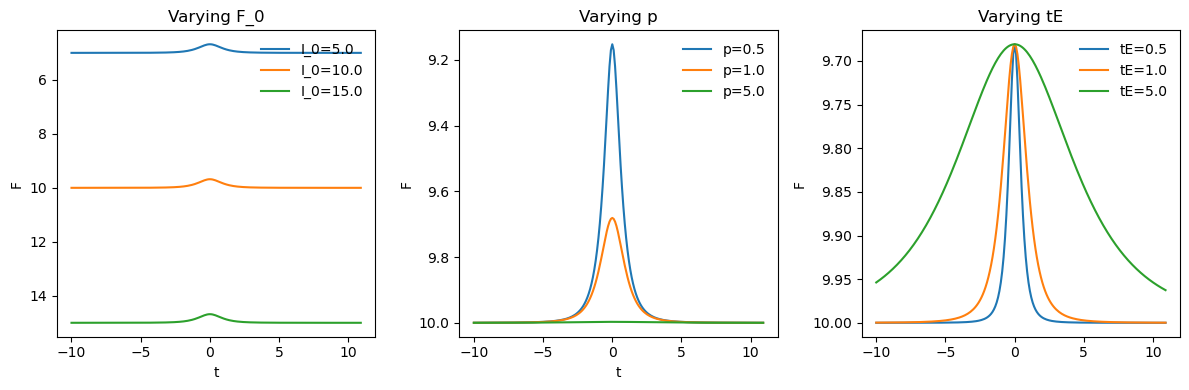

In [4]:
def logmodel(I_0, p, tmax, tE, t):   
    u = np.sqrt(p**2 + ((t-tmax)/tE)**2) 
    I = I_0 - 2.5*np.log10(((u**2. + 2)/(u*np.sqrt(u**2 + 4))))
    return I

tE = 1
p = 1
I_0 = 10.

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 4))
ax1, ax2, ax3 = axs

for Ix in [5, 10, 15]:
    ax1.plot(tarr, logmodel(Ix, p, tmax, tE, tarr), label=f'I_0={Ix:.1f}')
ax1.legend(frameon=False)
ax1.set_xlabel('t')
ax1.set_ylabel('F')
ax1.invert_yaxis()
ax1.set_title('Varying F_0')

for px in [0.5, 1, 5]:
    ax2.plot(tarr, logmodel(I_0, px, tmax, tE, tarr), label=f'p={px:.1f}')
ax2.legend(frameon=False)
ax2.set_xlabel('t')
ax2.set_ylabel('F')
ax2.invert_yaxis()
ax2.set_title('Varying p')

for tx in [0.5, 1, 5]:
    ax3.plot(tarr, logmodel(I_0, p, tmax, tx, tarr), label=f'tE={tx:.1f}')
ax3.legend(frameon=False)
ax2.set_xlabel('t')
ax3.set_ylabel('F')
ax3.set_title('Varying tE')
ax3.invert_yaxis()
fig.tight_layout()

### OK, so now we need a reasonable initial guess for Emcee


### I_0 is roughly the baseline level of the flux which for my real light curve looks like 17.25 ish

### p is something like a peak magnification. p of 0.5 seems to cause a 0.8 mag change, while p of 1 seems to cause a 0.25 mag change. Ours is somewhere in between so we'll try p=0.75

### tE is roughy the half-width at half-maximum. Our event seems to last roughly a 100 days FWHM, so we'll take half that as our initial guess.

### Finally, our peak looks somewhere around HJD=2458500.

### You can do way better with using some simple stats that you've already learned about this semester, but I'm deliberately winging it by doing this by eye... because you should *LOOK AT YOUR DATA!*

### Let's just look at those guesses vs the model.

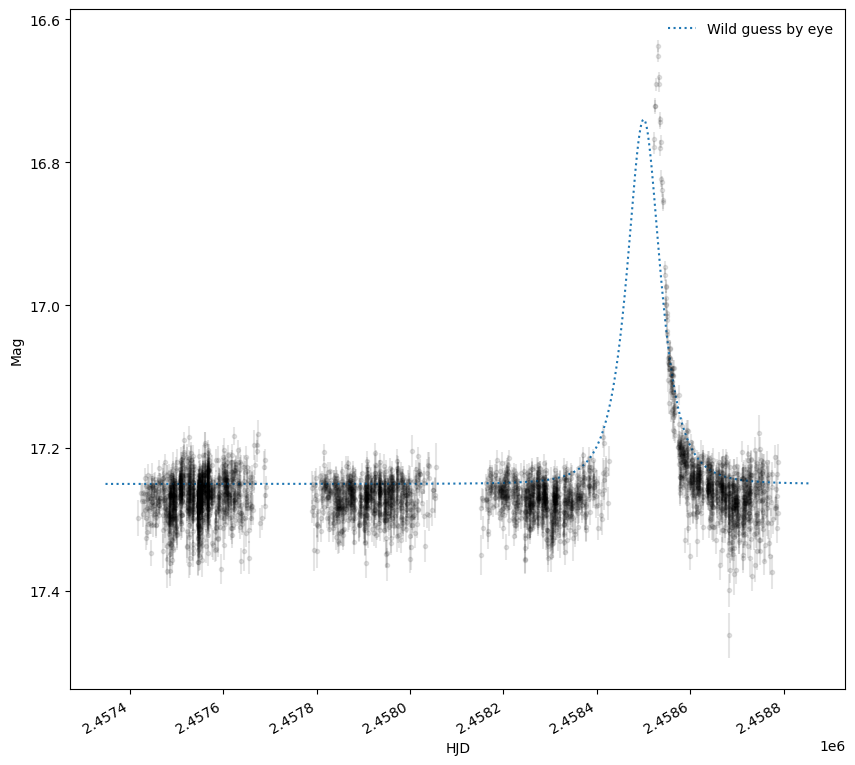

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(data['t'], data['y'], yerr=data['dy'],\
            linestyle='None', marker='.', color='k', alpha=0.1)
ax.invert_yaxis()
tmin, tmax = ax.get_xlim()
tarr = np.arange(tmin, tmax+0.1, 0.1)
guess = [17.25, 0.75, 2458500, 50]
ax.plot(tarr, logmodel(*guess, tarr), ls=':', color='C0', label='Wild guess by eye')
ax.set_xlabel('HJD')
ax.set_ylabel('Mag')
ax.legend(frameon=False)
fig.autofmt_xdate()

In [6]:
# it should be obvious here that the errors are underestimated - look at the scatter
# of the points vs the size of the error bars
# we can use the measurements in the first couple of years to get a sense for
# how badly underestimated it is

indt = (data['t'] > data['t'].min()) & (data['t'] < data['t'].min()+365*2.)

# we can compare the variance of the measurements with the noise
print("Stdev of measurements:" , np.std(data['y'][indt]))
print("Median measurement error:", np.median(data['dy'][indt]))
unoise = np.sqrt(np.std(data['y'][indt]) **2. - np.median(data['dy'][indt])**2.)
print("Underestimated noise:", unoise)
# this is a high-ish value so we'll add it to the denominator of our chi-squared

Stdev of measurements: 0.028435891595947022
Median measurement error: 0.015
Underestimated noise: 0.024157813039603782


#### You could refine your guess as well with e.g. scipy.optimize. You already know how to do this with something simple like maximum likelihood! You also know how to get an initial estimate for reasonable step sizes in each direction - you'd like to step by roughly some factor of the variance of each of the parameters. This is just the Hessian Inverse/Fisher Information, which scipy.optimize will kindly give us.

## Hint: If you are stuck on the homework with emcee, try scipy.optimize first

In [7]:
# we'll define a (reduced) chisq function for convenience
def chisq(x, *args):
    I_0, p, tmax, tE = x
    t, y, dy = args
    mod = logmodel(I_0, p, tmax, tE, t)
    chisq = np.sum(((y - mod)**2.)/(dy**2. + unoise**2.))/(len(t) -4)
    return chisq 
    
# and a log likelihood function for Emcee
# note that Emcee really does want the actual honest to goodness likelihood
# not reduced chi-squared, so I multiply by the number of degrees of freedom
# otherwise the likelihood and prior would not have the right
# relative normalization
def LogLikelihood(I_0, p, tmax, tE, t, y, dy):
    x = (I_0, p, tmax, tE)
    args = (t, y, dy)
    negLogLike = chisq(x, *args)*(len(t) -4)
    return -negLogLike/2.

# we'll set some very loose bounds on each parameter
bounds = [(15, 18), (0, 3), (2458400, 2458600), (10, 70)]

# we need to pass the data to scipy.optimize
args = (data['t'], data['y'], data['dy'])

# if you wnat to see how to use scipy.optimize, here's an example 
# uncomment lines with a #####
##### res = so.minimize(chisq, guess, args=args, bounds=bounds)
##### print(res)


# without scipy, I need some scale to start the walkers - ones will do...
sigmas = np.ones(4)

# if you use scipy.optimize you can use the Hessian inverse 
# to set the position for emcee's walkers
# this choice is good because it should ensure we sample the distribution well.
##### sigmas = np.diag(res.hess_inv.todense())**0.5
##### print('Sigmas =', sigmas)
# there's a line further on with a plot of the result with scipy if you run this

### Next, we need a prior

In [8]:
def LogPrior(I_0, p, tmax, tE):
    
    # we can put some big bounds on the parameters
    if (I_0 >= 18  or I_0 <= 15) or\
        (p <= 0 or p >= 3)  or\
        (tE <= 10 or tE > 70) or\
        (tmax <= 2458400 or tmax >= 2458600):   
        return -np.inf
    
    # we can also make the priors non-trivial
    # but we also know we want the priors to be somewhat uninformative
    # the data should determine the model parameters, not the prior
    # so I'll make the widths very wide
    p_I0 = st.norm.pdf(I_0, loc=1.72653507e+01, scale=1.)
    p_p = st.norm.pdf(p, loc=6.87406601e-01, scale=1.)
    p_tmax = st.norm.pdf(tmax, loc=2.45852788e+06, scale=10.)
    p_tE = st.norm.pdf(tE, loc=2.54557543e+01, scale=10.)
    prior = p_I0*p_p*p_tmax*p_tE
    
    lnprior = np.log(prior)
    return lnprior

### Finally, we need the posterior - or really the log of the posterior for our work

In [9]:
def LogPosterior(params, t=None, y=None, dy=None):
    I_0, p, tmax, tE = params
    lnlike = LogLikelihood(I_0, p, tmax, tE, t, y, dy)
    lnprior = LogPrior(I_0, p, tmax, tE)
    lnposterior = lnlike + lnprior
    return lnposterior

### And that's everything we need - I'll initalize the walkers with my guess. If you ran scipy.optimize, you could start with that instead

In [10]:
nwalkers = 20
kwargs = {'t':data['t'], 'y':data['y'], 'dy':data['dy']}

# we'll initialize the walkers in a small ball around our best fit position - they'll meander away in the next step
p0 = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers, ndim)

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs=kwargs )
state = sampler.run_mcmc(p0, 1000) # do a little burn-in - note that this may not be enough - you should check 
sampler.reset()                    # your traceplot at the end to decide - but it's a way to start the walkers off 
                                   # in more random locations - we'll discard these 1000 steps entirely
                                    
# run the chain in production
# I'll do 10,000 steps. This is complete overkill.
sampler.run_mcmc(state, 10000, progress=True);

# we've asked for 10,000 steps x 20 walkers, so our chain should be [10000, 20, 4]

100%|█████████████████████████████████████| 10000/10000 [02:48<00:00, 59.23it/s]


In [12]:
samples = sampler.get_chain(flat=True) # you can flatten the chain - essentially concatenate the walkers
samples.shape                          # so now you've got 20 * 10000, 4 samples

(200000, 4)

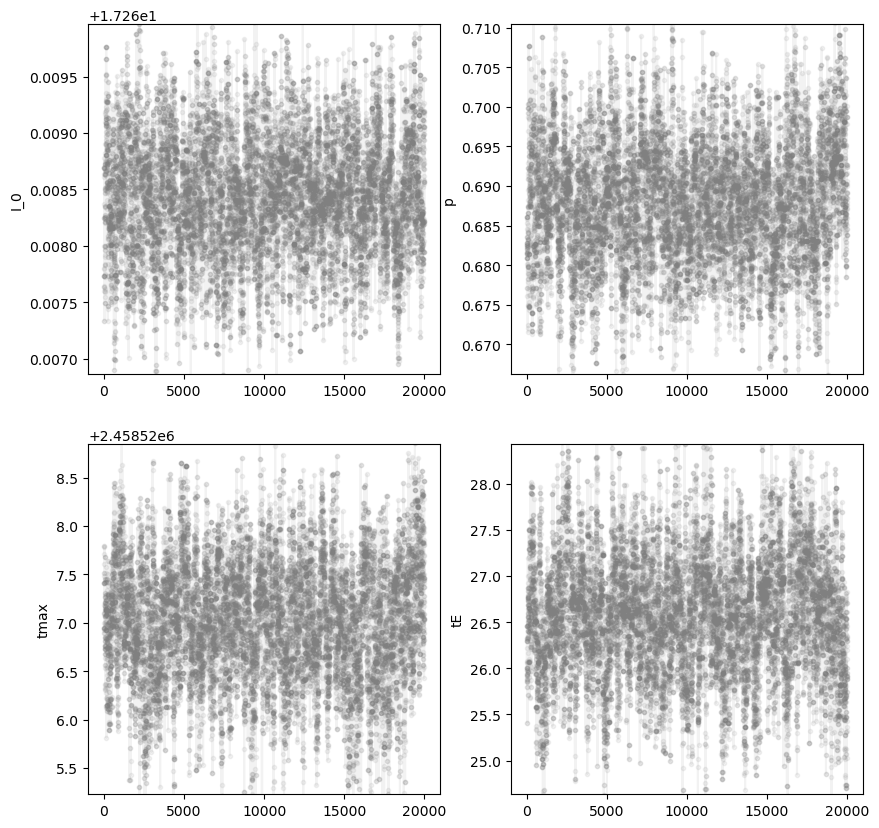

In [13]:
# we can visualize the chains
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
labels=['I_0', 'p', 'tmax', 'tE']
for i in range(samples.shape[1]):
    j, k = np.unravel_index(i, (2,2))
    ax = axs[j][k]
    ax.plot(samples[::10,i], linestyle='-', color='grey', marker='.', alpha=0.1)
    med = np.median(samples[:,i])
    std = np.std(samples[:,i])
    ax.set_ylim(med-3*std, med+3*std) 
    ax.set_ylabel(labels[i])

## It's hard to see what the burn-in is here because my initial guess by eye wasn't terrible. Let's discard 10% at the start as burnin just to be conservative. We'll also take every 10th sample to reduce the correlation between samples on the chains (see lecture 6 for thinning)


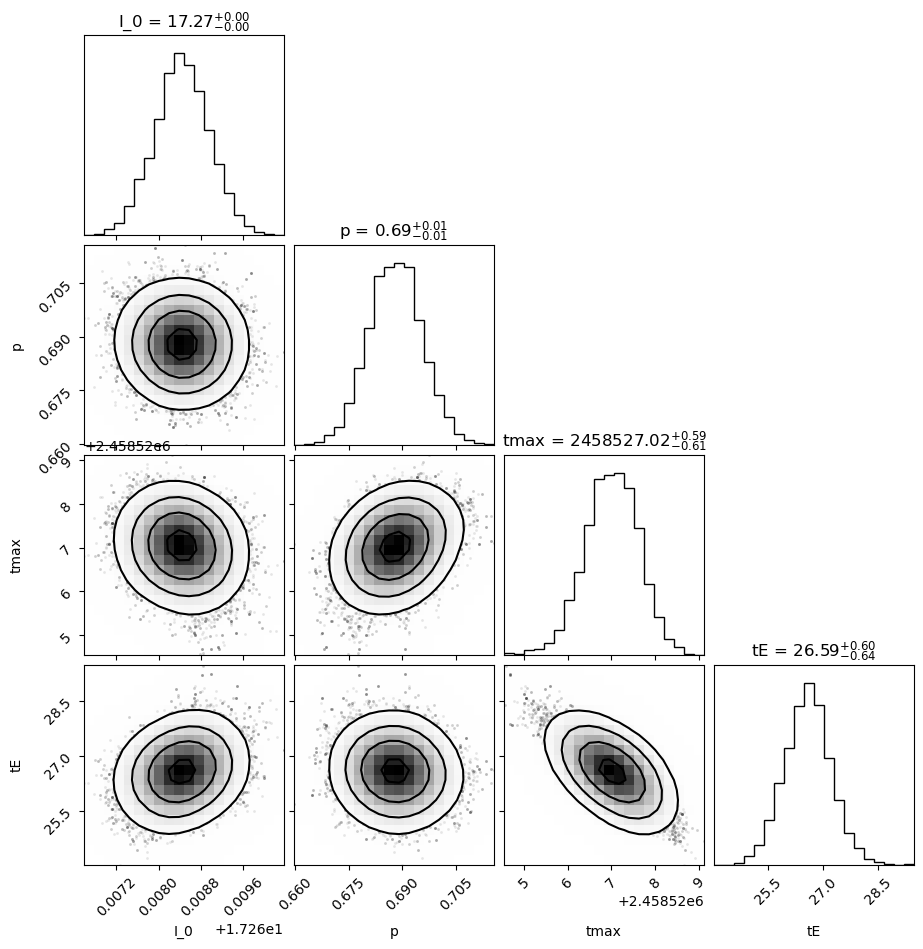

In [14]:
fig = corner.corner(samples[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

In [15]:
# You have all the samples so you can ask for the 16 and 84th percentile 
# to set uncertainties
mcmc_res = np.percentile(samples[1000::10,:], [50, 16, 84], axis=0)

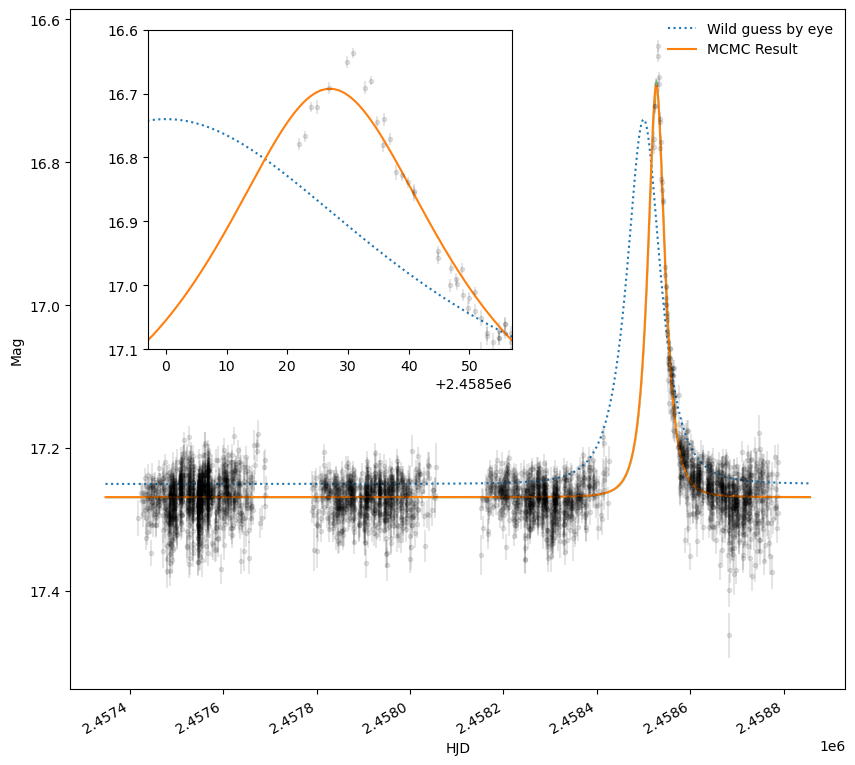

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# plot the data 
ax.errorbar(data['t'], data['y'], yerr=data['dy'],\
            linestyle='None', marker='.', color='k', alpha=0.1)
ax.invert_yaxis() 
tmin, tmax = ax.get_xlim()

# compare against our original guess
tarr = np.arange(tmin, tmax+0.1, 0.1)
guess = [17.25, 0.75, 2458500, 50]
ax.plot(tarr, logmodel(*guess, tarr), ls=':', color='C0', label='Wild guess by eye')


# you can use the MCMC 16th and 84th percentile to make an uncertainty region
ax.fill_between(tarr, logmodel(*mcmc_res[1], tarr), logmodel(*mcmc_res[2], tarr),\
                    color='C2', alpha=0.3)
# and report the median value as the "Result"
ax.plot(tarr, logmodel(*mcmc_res[0], tarr), ls='-', color='C1', label='MCMC Result')


# we can also compare the detailed fit
axins = ax.inset_axes([0.1, 0.5, 0.47, 0.47])
axins.errorbar(data['t'], data['y'], yerr=data['dy'],\
            linestyle='None', marker='.', color='k', alpha=0.1)
axins.plot(tarr, logmodel(*guess, tarr), ls=':', color='C0')
axins.plot(tarr, logmodel(*mcmc_res[0], tarr), ls='-', color='C1')
axins.set_xlim(mcmc_res[0][2] - 30., mcmc_res[0][2] + 30. )
axins.set_ylim(17.1, 16.6)


# if you ran with scipy.optimize, you can uncomment this 
##### ax.plot(tarr, logmodel(*res.x, tarr), ls='--', color='C2',\
#####          label='Refined with a local optimizer')


ax.set_xlabel('HJD')
ax.set_ylabel('Mag')
ax.legend(frameon=False)
fig.autofmt_xdate()